In [1]:
import pandas as pd
import numpy as np
import numpy.ma as ma
import math

import plotly.graph_objects as go
import matplotlib
import matplotlib.pyplot as plt
import geopandas
from mpl_toolkits.basemap import Basemap

import netCDF4
import xarray as xr

# Understanding .nc datatype

.nc file contain geo information including longitude, latitude, time and the parameter of interest such as, sea surface temperature, emissions or precipitation. In order to plot the graph, we need to match the dimension of the longitude and latitude of the map to the matrix of the parameter of intereest. In the graph, we choose to take the average of the parameter of interest with respsect to time.

In this section, we are using netCDF4 to retrieve information from the .nc file and using matplotlib/basemap to plot the resulting graph.

## Sea surface temperature EDA (sst)

The following is the EDA and plot of the sea surface temperature. In general, we can clearly see the sea surface temperature is highest near the equator and the lowest near the poles from the plot. However, some of the sea surface temperature appears to be affected near the coast line. For example, one of the most promenent fishing grounds in Canada, the Hibernia shelf off Newfoundland, displays colder ocean temperature when compared to the same latitude in the Atlantic.

dict_keys(['lat', 'lon', 'sst', 'time', 'time_bnds'])


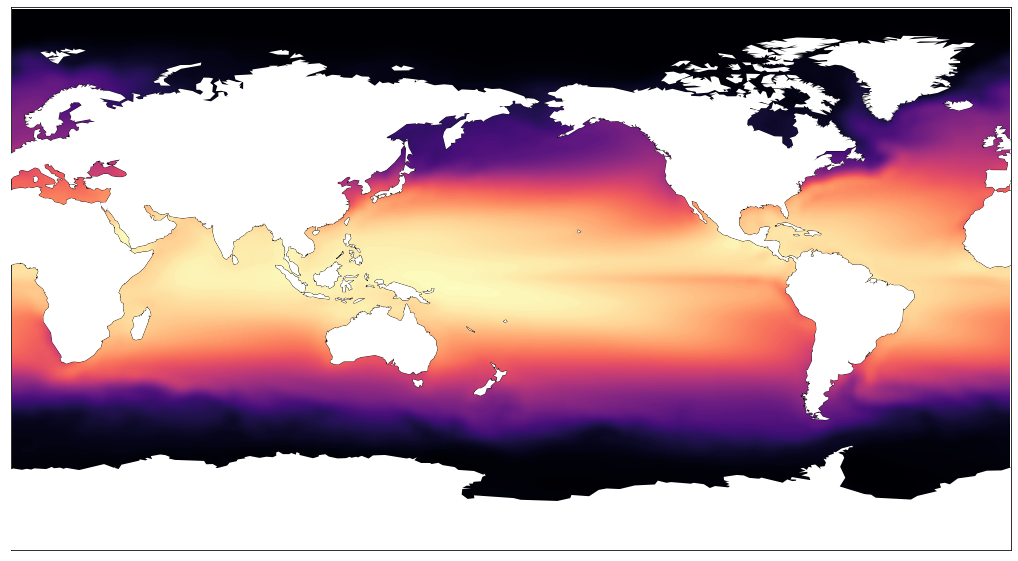

In [2]:
nc_file = '../data/sst_noaa.nc'
nc = netCDF4.Dataset(nc_file, mode='r', compression='gzip')
print(nc.variables.keys())

sst = ma.array(nc.variables['sst'][:,:,:])
lats = nc.variables['lat'][:]
lons = nc.variables['lon'][:]
sst1 = sst.data
sst_mean = np.mean(sst1,axis=0)

m = Basemap(projection='gall',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=0,urcrnrlon=360, resolution='c')

lon, lat = np.meshgrid(lons, lats)
xi, yi = m(lon, lat)

fig,ax=plt.subplots(figsize=(20,10))
cs = m.contourf(xi,yi,np.squeeze(sst_mean),  cmap='magma', levels=300)
m.fillcontinents(color='white',lake_color='white',zorder=10)
m.drawcoastlines(linewidth=0.7, zorder=10)


## Add sst as feature

The following section add in sea surface temperature features to training data. Transforming .nc data from a longitude range of 0 - 360 to -180 - 180. Round all df longitude and latitude data to nearest 0.5 degree with a resolution of 1 degree. Adjust time to datetime formal with date (or month) only format.

One of the limitations we find in adding features is the grid of longitude and latitude. All datasets have different set of standards (different decimal places) when matching parameters to longitude and latitude grid. As such, our data can only be accurate to the largest grid format in order to join the df. Another limitation is that our local computer cannot handle large join operations.

In [3]:
nc_sst = xr.open_dataset('../data/sst_noaa.nc')
df_sst = nc_sst.to_dataframe()
df_sst = df_sst[(df_sst['time_bnds'].dt.year > 2011) & (df_sst['time_bnds'].dt.year  < 2017)]
df_sst.reset_index(level=[0,1], inplace=True)

In [4]:
# def custom_round(x):
#     return 0.5 * round(float(x)/0.5)

# df_winter = df[(df.index.get_level_values('time') < '2015-02-28') | \
#                (df.index.get_level_values('time') > '2015-11-01')]
# df_winter = df_winter.groupby(level=['lat', 'lon']).mean()
# df_winter

df_sst['time_bnds'] = df_sst['time_bnds'].dt.to_period('M')
df_sst['lon'] = df_sst['lon'] - 180
df_sst_gb = df_sst.groupby(['lat', 'lon', 'time_bnds']).mean()
df_sst_gb.reset_index(level=[0,1,2], inplace=True)
df_sst_gb.to_csv('../data/sst_grid.csv')
df_sst_gb

,lat,lon,time_bnds,sst
0,-89.5,-179.5,2012-01,-1.79
1,-89.5,-179.5,2012-02,-1.79
2,-89.5,-179.5,2012-03,-1.79
3,-89.5,-179.5,2012-04,-1.79
4,-89.5,-179.5,2012-05,-1.79
...,...,...,...,...
3887995,89.5,179.5,2016-08,-1.80
3887996,89.5,179.5,2016-09,-1.80
3887997,89.5,179.5,2016-10,-1.80
3887998,89.5,179.5,2016-11,-1.80


### Test adding sst to AIS training data as additional feature

The section attempts to join the above sst to the trollers dataset as extra feature. The steps including dropping data that is has 'is_fishing' = -1. Adjusting the time, longitude, latitude format to match the sst dataframe. Then both df is joined together with the 'is_fishing' column as label and other columns as features.

In [5]:
path = '../data/trollers.csv'

fishing_df = pd.read_csv(path)
fishing_df = fishing_df[fishing_df['is_fishing'] > -0.5]
fishing_df['is_fishing'] = [0 if x < 0.3 else 1 for x in fishing_df['is_fishing']]
fishing_df = fishing_df[['is_fishing', 'lat', 'lon', 'course', 'speed', 'timestamp', 'distance_from_shore', 'distance_from_port', 'mmsi', 'source']]

In [6]:
def custom_round(x): 
    return 0.5 + np.floor(float(x))

fishing_df['adjust_lat'] = fishing_df['lat'].apply(lambda x: custom_round(x))
fishing_df['adjust_lon'] = fishing_df['lon'].apply(lambda x: custom_round(x))
fishing_df["adjust_time_date"] = pd.to_datetime(fishing_df['timestamp'], unit='s').dt.date
fishing_df["adjust_time"] = pd.to_datetime(fishing_df["adjust_time_date"]).dt.to_period('M')

In [7]:
df_all = pd.merge(fishing_df, df_sst_gb,  how='left', \
                  left_on=['adjust_lat','adjust_lon', 'adjust_time'], \
                  right_on = ['lat','lon', 'time_bnds'])
df_all = df_all.drop(columns=['lat_y', 'lon_y', 'time_bnds'])
df_all.to_csv('../data/feature_1.csv')
df_all

,is_fishing,lat_x,lon_x,course,speed,timestamp,distance_from_shore,distance_from_port,mmsi,source,adjust_lat,adjust_lon,adjust_time_date,adjust_time,sst
0,1,38.243591,15.655180,309.200012,3.0,1.431005e+09,999.975464,11661.617188,7.652701e+13,gfw,38.5,15.5,2015-05-07,2015-05,13.099999
1,1,38.245487,15.658214,242.199997,8.4,1.431006e+09,999.975464,13038.084961,7.652701e+13,gfw,38.5,15.5,2015-05-07,2015-05,13.099999
2,1,38.245098,15.661433,311.200012,7.4,1.431007e+09,0.000000,12529.657227,7.652701e+13,gfw,38.5,15.5,2015-05-07,2015-05,13.099999
3,1,38.234615,15.640217,72.900002,6.1,1.431008e+09,0.000000,9433.749023,7.652701e+13,gfw,38.5,15.5,2015-05-07,2015-05,13.099999
4,1,38.240871,15.660789,340.399994,6.8,1.431009e+09,0.000000,12529.657227,7.652701e+13,gfw,38.5,15.5,2015-05-07,2015-05,13.099999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7840,0,41.267307,36.381233,275.799988,0.0,1.446350e+09,0.000000,5830.808594,2.740638e+14,gfw,41.5,36.5,2015-11-01,2015-11,16.388000
7841,0,41.267307,36.381222,12.000000,0.0,1.446351e+09,0.000000,5830.808594,2.740638e+14,gfw,41.5,36.5,2015-11-01,2015-11,16.388000
7842,0,41.267334,36.381226,356.500000,0.0,1.446352e+09,0.000000,5830.808594,2.740638e+14,gfw,41.5,36.5,2015-11-01,2015-11,16.388000
7843,0,41.267319,36.381226,0.000000,0.0,1.446353e+09,0.000000,5830.808594,2.740638e+14,gfw,41.5,36.5,2015-11-01,2015-11,16.388000
